# **GROUP PROJECT**

https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-74759-0_345

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import geopandas as gpd
import random
from deap import base, creator, tools
import pyproj
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ortools as ort
import datetime as dt
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

# **1. Problem Variables**

In [ ]:
# truck variables
truckRange = 10
truckCapacity = 500
nCities = 30
M = 10

# **2. SET UP CITIES**

In [3]:
def buildCityDF(nCities,gridX=100,gridY=100):
    xs = np.random.randint(0,gridX,nCities)
    ys = np.random.randint(0,gridY,nCities)
    pts = [Point(xs[i],ys[i]) for i in range(0,nCities)]
    demands = np.random.randint(0,101,nCities)
    facilityOneCosts = np.random.randint(0,101,nCities)
    facilityTwoCosts = np.random.randint(100,201,nCities)
    cityIndices = range(0,nCities)
    cities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts})
    return cities

In [ ]:
cities = buildCityDF(nCities)

# **3. DIVIDE UP CITIES INTO SUB-TOURS TO BE SOLVED USING TSP**

In [4]:
def buildDistanceMatrix_Euclidean(cities):
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    return distances

In [ ]:
def solveOriginal(cities,M = 100):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()

    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates}
    yj = {j: model.IntVar(0,1, 'y[%i]' % (j)) for j in range_facilityCandidates}
    
    obj = [(cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + 2*cij[0,j]*yj[j] for i in range_customers for j in range_facilityCandidates]
    
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
        
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
            
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= yj[j])
            
    for j in range_facilityCandidates:
        #model.Add(yj[j] <= M)
        model.Add(model.Sum([yj[j] for j in range_facilityCandidates]) <= M)
        

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    resultGDF["Status"] = [yj[j].solution_value() for j in range_facilityCandidates]
    
    return model,yj,xij,resultGDF,status

In [ ]:
m,yj,xij,resultGDF,status = solveOriginal(cities,M=M)

In [ ]:
# do location problem first, then solve routing problem

In [ ]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y})")
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

# **4. SOLVE TSP SUB-TOURS**

## **4.1 FIND INITIAL POPULATIONS**

In [ ]:
def buildEdgeDf_Geo(df):
    edgeIDs = []
    sources = []
    destinations = []
    weights = []
    edgeID = 0
    for i,row in df.iterrows():
        sourceID = row["City Index"]
        sourceGeometry = row["geometry"]
        for j,row in df.iterrows():
            if j > i:
                destID = row["City Index"]
                destGeometry = row["geometry"]
                distance = sourceGeometry.distance(destGeometry)
                edgeIDs.append(edgeID)
                sources.append(sourceID)
                destinations.append(destID)
                weights.append(distance)
                edgeID += 1
    df_links = pd.DataFrame({"Edge":edgeIDs,"Source":sources,"Destination":destinations,"weight":weights})
    return df_links

In [ ]:
def buildMinimumSpanningTree(df):
    """
    Utilizes Kruskal's algorithm
    """
    # 0. create dataframe of edges with weight, source, and destination
    if type(df) == gpd.geodataframe.GeoDataFrame:
        df_links = buildEdgeDf_Geo(df).sort_values("weight")
    else:
        df_links = buildEdgeDf(df).sort_values("weight")
    
    # 1. load all nodes into a graph
    graph = nx.Graph()
    graph.add_nodes_from(df.index)
    # 2. Implement Kruskal's algorithm by adding each edge in order by weight so long as it does not create a cycle
    for i,row in df_links.iterrows():
        verticesReached = []
        source = row["Source"]
        destination = row["Destination"]
        weight = row["weight"]
        graph.add_edge(source,destination)
        cyclesInGraph = nx.cycle_basis(graph)
        if len(cyclesInGraph) > 0: # check for cycle and remove edge if one is created
            graph.remove_edge(source,destination)
        if len(graph.edges) == len(graph.nodes) - 1:
            break
    # check results
    fullgraph = nx.from_pandas_edgelist(df_links,source="Source",target="Destination",edge_attr="weight")
    mst = nx.minimum_spanning_tree(fullgraph)
    isSameGraph = nx.is_isomorphic(graph,mst)
    print(f"The MST algorithm matches that of NetworkX: {isSameGraph}")
    return df_links,graph

In [ ]:
# duplicate every edge on the MST
def duplicateEdges(df_links):
    edgeID = max(df_links["Edge"]) + 1
    for i,row in df_links.iterrows():
        destination = row["Destination"] # flip these because directed!
        source = row["Source"] # flip these because directed!
        weight = row["weight"]
        df_links = df_links.append({"Edge":edgeID,"Source":destination,"Destination":source,"weight":weight},ignore_index=True)
        edgeID += 1
    df_links.index = df_links["Edge"]
    return df_links

In [ ]:
def findNearestNodeNotAlreadyInSet(currentNodeID,df_links_geo_bidirectional,citiesNotInPath):
    df_edgesStartingAtCity = df_links_geo_bidirectional[df_links_geo_bidirectional["Source"]==currentNodeID].sort_values("weight")
    for i,row in df_edgesStartingAtCity.iterrows():
        destinationID = row["Destination"]
        if destinationID in citiesNotInPath:
            #addCityToPath(destinationID)
            return destinationID

In [ ]:
def addCityToPath(citiesInPath,citiesNotInPath,cityID):
    citiesInPath.append(cityID)
    citiesNotInPath.remove(cityID)
    return citiesInPath,citiesNotInPath

In [ ]:
def generateStartingPopulation(dfTourSubset):
    startingPopulation = []
    df_links_geo,graph_geo = buildMinimumSpanningTree(dfTourSubset)
    df_links_geo_bidirectional = duplicateEdges(df_links_geo)
    for startNode in dfTourSubset["City Index"]:
        citiesInPath = []
        citiesNotInPath = [cityIndex for cityIndex in dfTourSubset["City Index"]]
        currentNode = startNode
        while len(citiesNotInPath) > 0:
            citiesInPath,citiesNotInPath = addCityToPath(citiesInPath,citiesNotInPath,currentNode)
            nextNode = findNearestNodeNotAlreadyInSet(currentNode,df_links_geo_bidirectional,citiesNotInPath)
            currentNode = nextNode
        citiesInPath = [int(cityID) for cityID in citiesInPath]
        startingPopulation.append(citiesInPath)
    return startingPopulation

In [ ]:
for cluster in set(resultGDF["assignment"]):
    dfTourSubset = resultGDF[resultGDF["assignment"]==cluster]
    startingPopulation = generateStartingPopulation(dfTourSubset)
    print(startingPopulation)

In [ ]:
def drawTourOnMap():
    return 0

## **4.2 USE GA TO LOOK FOR IMPROVEMENTS TO TSP TOUR**

In [ ]:
## Min.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(nCities),nCities)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
def evaluate(individual,dfSubset):
    # loop through two indices at a time, querying their distance and adding, returning to the first node at the end
    score = 0.0
    source = individual[0]
    for i in range(1,len(individual)):
        destination = individual[i]
#         query = f"Source == {source} & Destination == {destination}"
#         distance = df_links.query(query)["weight"].min()
        distance = dfSubset.loc[source].geometry.distance(dfSubset.loc[destination].geometry)
#         distance = distanceMatrix[source-1,destination-1]
        score += distance
        source = destination
    # for the last individual
    source = individual[len(individual)-1]
    destination = individual[0]
#     distance = distanceMatrix[source-1,destination-1]
    distance = dfSubset.loc[source].geometry.distance(dfSubset.loc[destination].geometry)
#     query = f"Source == {source} & Destination == {destination}"
#     distance = df_links.query(query)["weight"].min()
    score += distance
    return score
toolbox.register("evaluate",evaluate)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

In [ ]:
class Runner:
    
    def __init__(self, toolbox,startingPopulation,dfSubset):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        self.startingPopulation = startingPopulation
        self.dfSubset = dfSubset
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual,self.startingPopulation)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    # https://deap.readthedocs.io/en/master/tutorials/basic/part1.html?highlight=seeding#seeding-a-population
    def initIndividual(icls, content):
        return icls(content)

    def initPopulation(self,pcls, ind_init, population):
        print("initPopulation")
#         return self.startingPopulation
        return pcls(ind_init(c) for c in self.startingPopulation)

    toolbox = base.Toolbox()

    toolbox.register("individual_guess", initIndividual, creator.Individual)
    toolbox.register("population_guess", initPopulation, list, toolbox.individual_guess, startingPopulation)
    
    def initializePopulation(self):
        print("initializePopulation")
        # perform a parameter sweep using nearest neighbor method
        return toolbox.population_guess()
    
    def Run(self):
#         population = self.toolbox.population(n=self.population_size)
        population = self.initPopulation(0,1,2)
        print(population)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [ ]:
%%time
POPULATION_SIZE = 150
N_ITERATIONS = 1000
N_MATINGS = 50
a = Runner(toolbox,startingPopulation[0],dfSubset)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')

_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('average by iteration')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average')

_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

# **5. SOLVE FOR CHARGING STATIONS**

In [ ]:
resultGDF.head()

In [ ]:
distances = buildDistanceMatrix_Euclidean(resultGDF) * 10

In [ ]:
distances[resultGDF.iloc[0]["City Index"],resultGDF.iloc[10]["City Index"]]

In [ ]:
fiz

In [ ]:
solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)

distances = buildDistanceMatrix_Euclidean(resultGDF)
powerDemandPerDistance = 5.0
dij = cij = distances * powerDemandPerDistance

alpha = penaltyForChargingTime = 75.0

beta = chargingSpeeds = np.array([100,200])

gamma = chargingCost = np.array([1,2])
fiz = facilityCost = resultGDF[["Facility One Cost","Facility Two Cost"]].as_matrix()


n_customers = cij.shape[0]
range_customers = range(n_customers)
n_facilityCandidates = cij.shape[1]
range_facilityCandidates = range(n_facilityCandidates)
demands = np.array(cities["demand"])
demands_sum = demands.sum()

tiz = {(i,z): model.IntVar(0,120, 't[%i,%i]' % (i,z)) for i in range_facilityCandidates for z in range(0,2)}

xiz = {(i,z): model.IntVar(0,1, 'x[%i,%i]' % (i,z)) for i in range_facilityCandidates for z in range(0,2)}

# obj = [alpha*xiz[i,z]*tiz[i,z] + gamma[z]*xiz[i,z]*tiz[i,z]*beta[z] + fiz[i,z]*xiz[i,z] for i in range_facilityCandidates for z in range(0,2)]
range_types = range(2)
obj = [fiz[i,z]*xiz[i,z] for i in range_facilityCandidates for z in range(0,2)]

# obj = [2*cij[0,j]*yj[j] for i in range_customers for j in range_facilityCandidates]

print("made objective")


# constraints
for j in range_facilityCandidates:
    model.Add(dij[0,j] < 100 + model.Sum([beta[z]*tiz[i,z] for z in range(0,2) for i in range(0,j)]))

for z in range(0,2):
    model.Add(xiz[0,z] < 1)
    model.Add(tiz[0,z] < 1)

model.Minimize(model.Sum(obj))
status = model.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Optimal Solution Found')

resultGDF2 = resultGDF.copy(deep=True)
resultGDF2["Status"] = [yj[j].solution_value() for j in range_facilityCandidates]



In [ ]:
def set_fitness(population):
        fitnesses = [ 
            (individual, toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)

In [ ]:
def get_offspring(population,nMatings=50):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                toolbox.mate(population[i1], population[i2])
            
            yield toolbox.mutate(offspring1)[0]
            yield toolbox.mutate(offspring2)[0]

In [ ]:
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    # https://deap.readthedocs.io/en/master/tutorials/basic/part1.html?highlight=seeding#seeding-a-population
    def initIndividual(icls, content):
        return icls(content)

    def initPopulation(pcls, ind_init, population):
        return pcls(ind_init(c) for c in population)

    toolbox = base.Toolbox()

    toolbox.register("individual_guess", initIndividual, creator.Individual)
    toolbox.register("population_guess", initPopulation, list, toolbox.individual_guess, startingPopulation)
    
    def initializePopulation(self):
        # perform a parameter sweep using nearest neighbor method
        return toolbox.population_guess()
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        #population = startingPopulation
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

# **Notes From Class**

In [ ]:
cities.head()

In [27]:
def solveOriginal(cities,M = 100,Rv=100,alpha=75.0):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()

    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(2)} # charging station location decision/ concentrator
    
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(2)]
    
    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(2)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(2)]) <= M)
        
    # Total tour length constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= Rv)
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(2)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

In [16]:
cities = buildCityDF(20)

In [31]:
model,yjz,xij,resultGDF,status = solveOriginal(cities,M=30,Rv=100,alpha=0.001)

Optimal Solution Found


Text(721.4, 0.5, 'City')

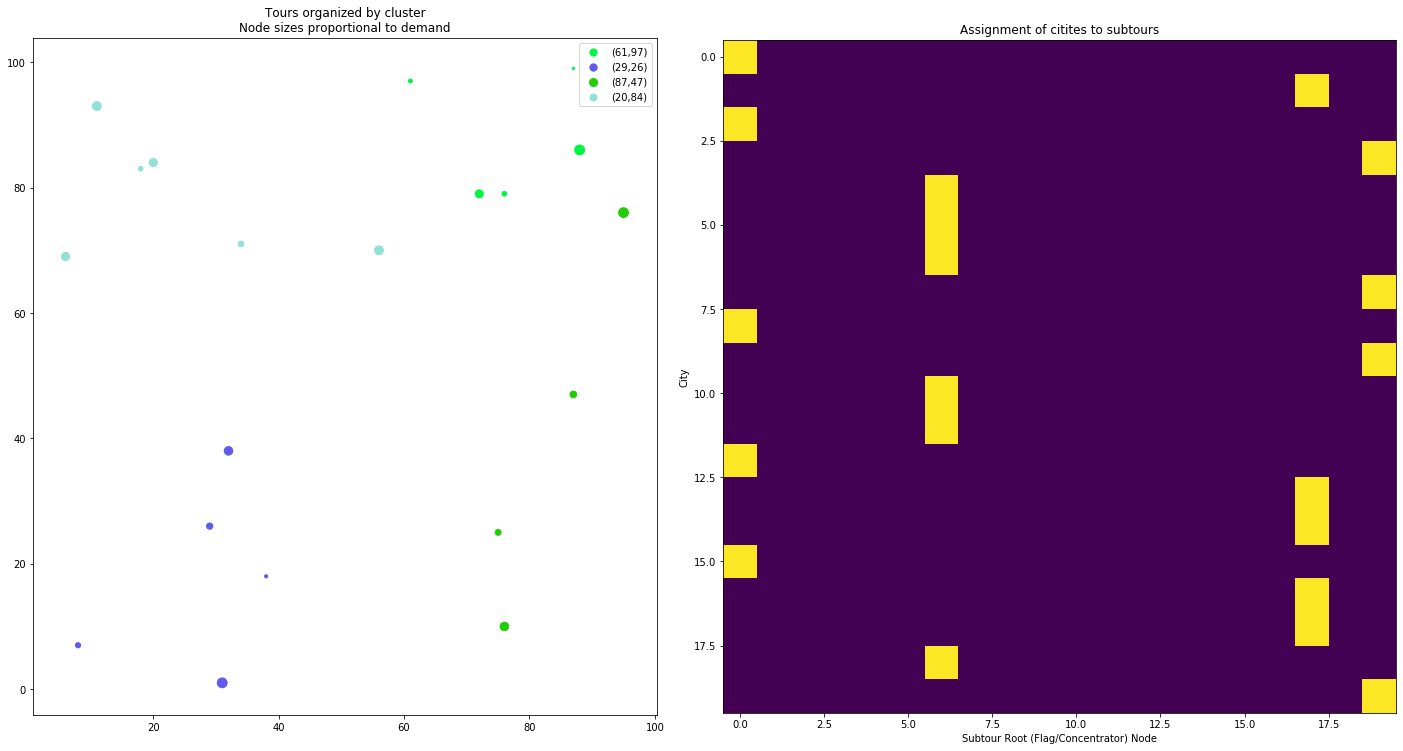

In [32]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y})")
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

# **A) CLEAN UP, CLEAN UP, EVERYBODY EVERYWHERE**

By Tomorrow
- TSP code  with GA
- Test segementation code for size, loop through and see how long it takes to run

# **CHECK HOW LARGE WE CAN DO**

In [ ]:
nCities = range(10,110,10)
gridX = 100
gridY = 100

In [ ]:
times = []
for nCity in nCities:
    startTime = dt.datetime.now()
    cities = buildCityDF(nCity,gridX=100,gridY=100)
    m,yj,xij,resultGDF,status = solveOriginal(cities)
    endTime = dt.datetime.now()
    totalTime = (endTime-startTime).total_seconds()
    times.append(totalTime)
    print(f"Completed {nCity} cities in {totalTime} seconds.  Optimal solution: {status == pywraplp.Solver.OPTIMAL}")

In [33]:
illinoisCitiesPath = "Final Presentation\\tl_2016_17_place\\tl_2016_17_place.shp"
illinois = gpd.read_file(illinoisCitiesPath)

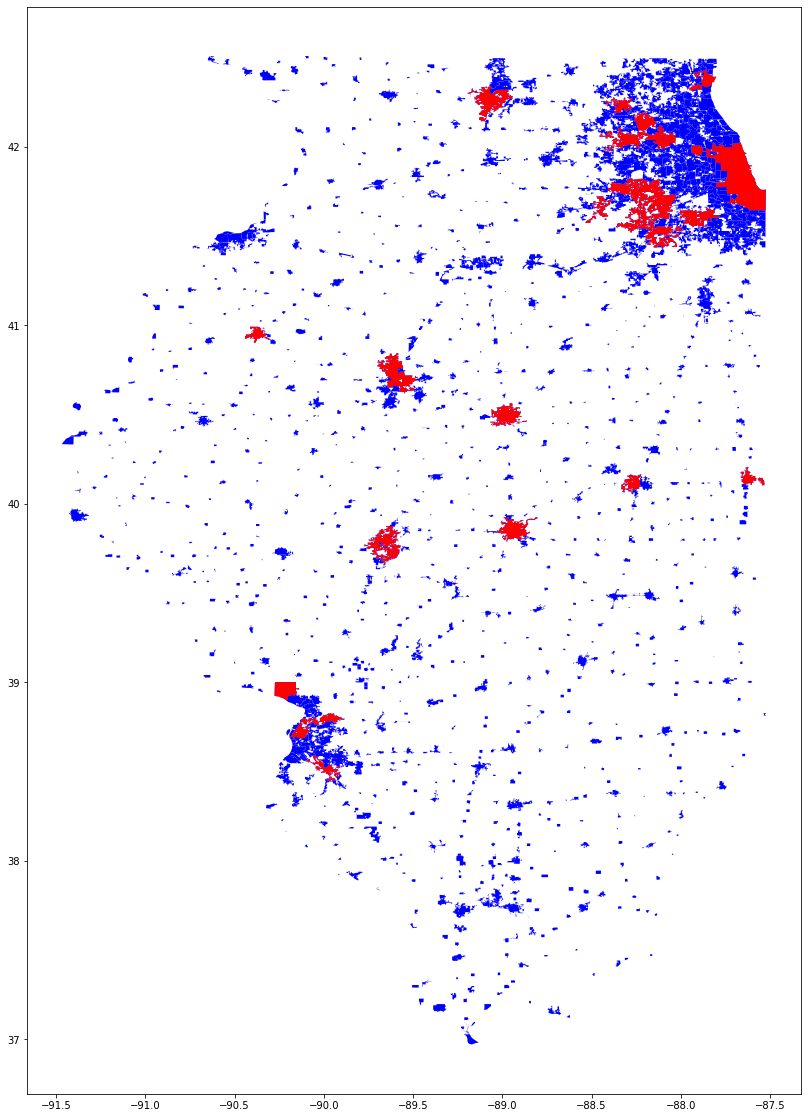

In [46]:
fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:30].plot(ax=ax,color="red")

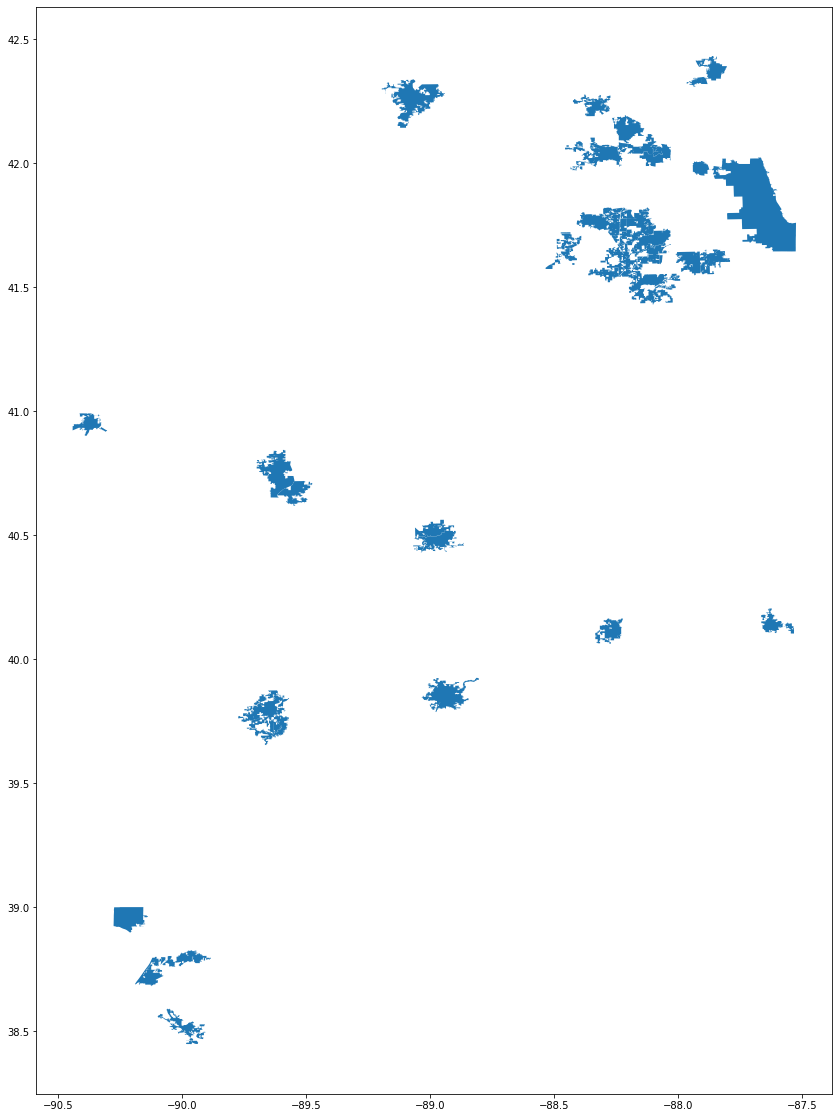

In [43]:
fig,ax = plt.subplots(figsize=(20,20))

illinois.sort_values("ALAND",ascending=False).reset_index()[0:30].plot(ax=ax)

DO OUTS
- Get TSP working